In [2]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import initializers


Using TensorFlow backend.


In [3]:
import pandas as pd
raw_data = pd.read_csv('MIMIC EMR.csv')

/Users/zuzu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## 病历文本 raw data
raw_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [5]:
# subject mortality table
mortality_data = pd.read_csv('subject_mortality_table.csv')

In [25]:
mortality_data.shape

(38983, 3)

In [10]:
# subject drug table
drug_data = pd.read_csv('subject_drug_table.csv')

In [121]:
drug_data['SUBJECT_ID'] = drug_data['Unnamed: 0']

In [122]:
drug_data.head()

,Unnamed: 0,D5W,Heparin Sodium,Nitroglycerin,Docusate Sodium,Insulin,Atropine Sulfate,Zolpidem Tartrate,Midazolam HCl,Nitroglycerin SL,...,Dexilant,dexlansoprazole (Dexilant),anu,Xyzal,Pacerone,Penicillin G Benzathine,ValGANCIclovi,Paroxetine Mesylate,Zanamivir,SUBJECT_ID
0,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
1,24,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,24
2,25,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,25
3,26,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,26
4,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27


In [8]:
# gender + age
info_data = pd.read_csv('personal_information.csv')

In [9]:
info_data.head()

,SUBJECT_ID,AgeGroup,Gender,Death,N
0,2,0,0,0,0
1,4,0,1,0,2
2,6,0,1,0,2
3,8,0,0,0,0
4,9,0,0,1,0


In [53]:
# add the mortality label to raw data
result1 = pd.merge(raw_data, mortality_data, on='SUBJECT_ID', how = 'right')

In [37]:
#filtered_df = df1[df1.Death.notnull()] 

In [54]:
result1.shape

(1344425, 13)

In [61]:
result1 = result1[['SUBJECT_ID','TEXT','Death','CATEGORY']]
result1 = result1.loc[:,~result1.replace(0,np.nan).isna().all()].dropna(axis=0,how='any',subset=['TEXT'])

In [62]:
finaldata = result1.groupby('SUBJECT_ID')['TEXT'].apply(lambda x: '. '.join(x)).reset_index()

In [63]:
finaldata.shape

(38611, 2)

In [65]:
finaldata.head()

,SUBJECT_ID,TEXT
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...
1,3,Admission Date: [**2101-10-20**] Discharg...
2,4,Admission Date: [**2191-3-16**] Discharge...
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...
4,6,Admission Date: [**2175-5-30**] Dischar...


In [15]:
# # subject ID, combined text description and mortality label
# finaldata2 = finaldata.merge(mortality_data, on='SUBJECT_ID', how='left')

In [67]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Admission Date:\s+\W{3}\d{4}\W\d*\W\d*\W{3}', '')

In [85]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Admission Date:\s*', '')

In [69]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Discharge Date:\s+\W{3}\d{4}\W\d*\W\d*\W{3}', '')

In [86]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Discharge Date:\s*', '')

In [72]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Date of Birth:\s+\W{3}\d{4}\W\d*\W\d*\W{3}', '')

In [87]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Date of Birth:\s*', '')

In [78]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Sex:\s*\w', '')

In [88]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'\W{3}\d{4}\W\d*\W\d*\W{3}', '')

In [90]:
finaldata['TEXT'] = finaldata['TEXT'].str.replace(r'Unit No:\s*\W*\w*\s\w*\s\w*\W*', '')

In [91]:
finaldata.head() #service, allegies, attending, chief complaint, history of illness

,SUBJECT_ID,TEXT
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...
1,3,\n\n \n\nService: Medicine\n\nCHIEF ...
2,4,\n\n \n\nService:\n\nCHIEF COMPLAINT:...
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...
4,6,\n\nService:\n\n\nADMISSION DIAGNOSIS:...


# documents 

In [92]:
documents = finaldata

In [93]:
documents['TEXT'].isnull().values.any()

False

In [94]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/zuzu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [95]:
stemmer = PorterStemmer()

In [96]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [20]:
#doc_sample = documents[documents['index'] == 4310].values[0][1]
#print('original document: ')
#words = []
#for word in doc_sample.split(' '):
#    words.append(word)
#print(words)
#print('\n\n tokenized and lemmatized document: ')
#print(preprocess(doc_sample))

# processed_docs (lemmatized)

In [97]:
processed_docs = documents['TEXT'].astype(str).map(preprocess)
processed_docs[:10]

0    [nurs, transfer, note, admit, nicu, sepsi, eva...
1    [servic, medicin, chief, complaint, admit, reh...
2    [servic, chief, complaint, short, breath, feve...
3    [triag, note, know, lastnam, deliv, week, gest...
4    [servic, admiss, diagnosi, stage, renal, disea...
5    [neonatolog, patient, term, infant, send, nicu...
6    [babygram, chest, port, clip, clip, number, ra...
7    [servic, neurolog, chief, complaint, weak, ina...
8    [servic, histori, present, ill, babi, girl, kn...
9    [servic, neurosurgeri, allergi, penicillin, at...
Name: TEXT, dtype: object

# Bag of words dataset

## create dictonary first

In [99]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 administ
1 admit
2 antibiot
3 apgar
4 ask
5 assess
6 attend
7 babi
8 bilater
9 blood
10 bowel


In [100]:
# word must appear >15 times, and no more than 50% documents
dictionary.filter_extremes(no_below=15, no_above=0.5)

## bow_corpus

In [101]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#bow_corpus[4310]

# Running LDA using Bag of Words

In [102]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=100, id2word=dictionary, passes=2, workers=2, iterations=500)

In [123]:
# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

# Bag of Words

In [135]:
train_vecs_bag = []
for i in range(0,len(bow_corpus),1):
    top_topics = lda_model.get_document_topics(bow_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    train_vecs_bag.append(topic_vec)

In [106]:
documents = documents.merge(mortality_data, on='SUBJECT_ID', how='left')

In [107]:
documents.head()

,SUBJECT_ID,TEXT,Unnamed: 0,Death
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,118,0
1,3,\n\n \n\nService: Medicine\n\nCHIEF ...,119,0
2,4,\n\n \n\nService:\n\nCHIEF COMPLAINT:...,120,0
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,121,0
4,6,\n\nService:\n\n\nADMISSION DIAGNOSIS:...,122,0


# unbalanced data using bag of words

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split


X = np.array(train_vecs_bag)
y = np.array(documents.Death)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


In [138]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,10196,116
True 1,670,602


In [139]:
import matplotlib.pyplot as plt 
%matplotlib inline

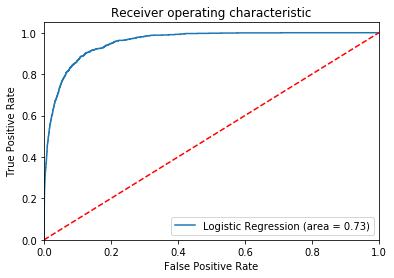

In [140]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## neural network

In [141]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier()
NN.fit(X_train,y_train)

/Users/zuzu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [142]:
y_pred_nn = NN.predict(X_test)
metrics.accuracy_score(y_test, y_pred_nn)

0.9539019337016574

In [143]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_nn), 
             columns=['Predicted 0','Predicted 1'],
             index=['True 0', 'True 1'])

,Predicted 0,Predicted 1
True 0,10094,218
True 1,316,956


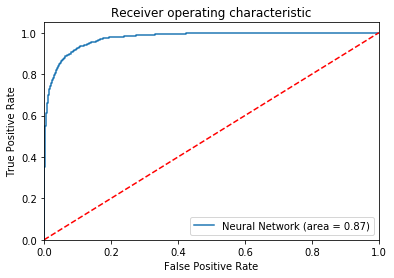

In [144]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, NN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, NN.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# combine all the features (topic + drug)

In [126]:
patient = pd.merge(documents, drug_data, on='SUBJECT_ID', how = 'left' )

In [148]:
patient.head()

,SUBJECT_ID,TEXT,Unnamed: 0_x,Death,Unnamed: 0_y,D5W,Heparin Sodium,Nitroglycerin,Docusate Sodium,Insulin,...,olopatadine,Dexilant,dexlansoprazole (Dexilant),anu,Xyzal,Pacerone,Penicillin G Benzathine,ValGANCIclovi,Paroxetine Mesylate,Zanamivir
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,118,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,\n\n \n\nService: Medicine\n\nCHIEF ...,119,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,\n\n \n\nService:\n\nCHIEF COMPLAINT:...,120,0,4,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,121,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,\n\nService:\n\n\nADMISSION DIAGNOSIS:...,122,0,6,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [145]:
df_bow = pd.DataFrame(train_vecs_bag)

In [146]:
df_bow.shape

(38611, 100)

In [149]:
patient_final = pd.concat([patient, df_bow], axis=1)

In [150]:
patient_final.head()

,SUBJECT_ID,TEXT,Unnamed: 0_x,Death,Unnamed: 0_y,D5W,Heparin Sodium,Nitroglycerin,Docusate Sodium,Insulin,...,90,91,92,93,94,95,96,97,98,99
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,118,0,2,0,0,0,0,0,...,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159
1,3,\n\n \n\nService: Medicine\n\nCHIEF ...,119,0,3,0,0,0,0,0,...,0.000004,0.000004,0.000004,0.000004,0.096523,0.000004,0.000004,0.000004,0.000004,0.000004
2,4,\n\n \n\nService:\n\nCHIEF COMPLAINT:...,120,0,4,1,0,0,1,1,...,0.000005,0.000005,0.066679,0.000005,0.000005,0.029803,0.000005,0.000005,0.000005,0.000005
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,121,0,5,0,0,0,0,0,...,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083
4,6,\n\nService:\n\n\nADMISSION DIAGNOSIS:...,122,0,6,1,1,0,1,1,...,0.000009,0.000009,0.000009,0.000009,0.010666,0.000009,0.000009,0.000009,0.000009,0.000009


# autoencoder

In [165]:
del patient_final['Unnamed: 0_x']

In [166]:
del patient_final['Unnamed: 0_y']

In [167]:
patient_final.head()

,SUBJECT_ID,TEXT,Death,D5W,Heparin Sodium,Nitroglycerin,Docusate Sodium,Insulin,Atropine Sulfate,Zolpidem Tartrate,...,90,91,92,93,94,95,96,97,98,99
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,0,0,0,0,0,0,0,0,...,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159
1,3,\n\n \n\nService: Medicine\n\nCHIEF ...,0,0,0,0,0,0,0,0,...,0.000004,0.000004,0.000004,0.000004,0.096523,0.000004,0.000004,0.000004,0.000004,0.000004
2,4,\n\n \n\nService:\n\nCHIEF COMPLAINT:...,0,1,0,0,1,1,0,0,...,0.000005,0.000005,0.066679,0.000005,0.000005,0.029803,0.000005,0.000005,0.000005,0.000005
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,0,0,0,0,0,0,0,0,...,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083
4,6,\n\nService:\n\n\nADMISSION DIAGNOSIS:...,0,1,1,0,1,1,0,0,...,0.000009,0.000009,0.000009,0.000009,0.010666,0.000009,0.000009,0.000009,0.000009,0.000009


In [168]:
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import initializers

In [169]:
X = np.array(patient_final.iloc[:,3:])
y = np.array(patient_final.Death)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [217]:
X_train_masked = X_train

np.random.seed(42)
mask = np.random.randint(0, 2, size=X_train_masked.shape[0]).astype(np.bool)

X_train_masked[mask] = 0

#model

Inputshape = X_train.shape[1]
# this is our input placeholder
inputLayer = Input(shape=(Inputshape,))
# building an encoder
encoder1 = Dense(1000, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=42))(inputLayer)
encoder2 = Dense(500, activation='relu')(encoder1)
encoder3 = Dense(200, activation='relu')(encoder2)
encoder4 = Dense(100, activation='relu')(encoder3)
encoder5 = Dense(50, activation='relu')(encoder4)
# buiding a decoder
decoder = Dense(100, activation='relu')(encoder5)
decoder = Dense(200, activation='relu')(decoder)
decoder = Dense(500, activation='relu')(decoder)
decoder = Dense(1000, activation='relu')(decoder)
decoder = Dense(Inputshape, activation='sigmoid')(decoder)

Autoencoder = Model(inputs=inputLayer, outputs=decoder)

Autoencoder.compile(optimizer='adam', loss='mean_squared_error') # also try mean_squared_error as loss function

#Autoencoder.summary()

print('# Fit model on training data')
model = Autoencoder.fit(X_train_masked, X_train,
                epochs=5,
                batch_size=30,
                verbose=1,
                shuffle=True,validation_data=(X_test, X_test))


# Fit model on training data
Train on 27027 samples, validate on 11584 samples
Epoch 1/5
27027/27027 [==============================] - 93s 3ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 2/5
27027/27027 [==============================] - 83s 3ms/step - loss: 0.0033 - val_loss: 0.0067
Epoch 3/5
27027/27027 [==============================] - 82s 3ms/step - loss: 0.0033 - val_loss: 0.0067
Epoch 4/5
27027/27027 [==============================] - 87s 3ms/step - loss: 0.0033 - val_loss: 0.0067
Epoch 5/5
27027/27027 [==============================] - 87s 3ms/step - loss: 0.0033 - val_loss: 0.0067


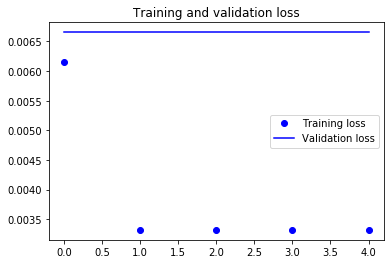

In [218]:
loss = model.history['loss']
val_loss = model.history['val_loss']
epochs = range(5)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [219]:
# loss
Autoencoder.evaluate(X_test, X_test, verbose=0)

0.006654331982856133

In [220]:
Autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 2914)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 1000)              2915000   
_________________________________________________________________
dense_62 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_63 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_64 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_65 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_66 (Dense)             (None, 100)               5100